In [1]:
# System
import os

# Data processing
import numpy as np

# Results presentation
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

# NN related stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

%matplotlib inline

In [2]:
N_CELLS_HOR = 200
N_CELLS_VER = 250

In [3]:
celled_data = torch.load("Data/celled_data_"
                         + str(N_CELLS_HOR)
                         + "x"
                         + str(N_CELLS_VER))
print (celled_data.shape)

torch.Size([9591, 1, 200, 250])


In [4]:
DEVICE_ID = 0
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(DEVICE_ID)
print (DEVICE)

cuda


### Создадим датасет

In [5]:
OBSERVED_DAYS = 64     # ~2 months
DAYS_TO_PREDICT_AFTER  = 10
DAYS_TO_PREDICT_BEFORE = 50
TESTING_DAYS = 1000

HEAVY_QUAKE_THRES = 3.5

In [6]:
freq_map = (celled_data>HEAVY_QUAKE_THRES).float().mean(dim=0)

In [7]:
class Dataset_RNN_Train (Dataset):
    def __init__(self, celled_data):
        self.data = celled_data[0:
                                (celled_data.shape[0] -
                                 TESTING_DAYS)]
        self.size = (self.data.shape[0] -
                     DAYS_TO_PREDICT_BEFORE)
        
        print ('self.data :', self.data.shape)
        print ('size      :', self.size)
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return (self.data[idx],
                torch.sum(self.data[(idx +
                                     DAYS_TO_PREDICT_AFTER):
                                    (idx +
                                     DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
                          dim=0,
                          keepdim=True).squeeze(0) > 0)
        



In [8]:
dataset_train = Dataset_RNN_Train (celled_data)

dataloader_train = DataLoader(dataset_train,
                              batch_size=1,
                              shuffle=False,
                              num_workers=1)


self.data : torch.Size([8591, 1, 200, 250])
size      : 8541


In [9]:
def train_network_RNN (RNN_cell,
                       device,
                       dataloader_train,
                       n_cycles=1,
                       learning_rate=0.0003,
                       earthquake_weight=1.,
                       lr_decay=1.):
    
    loss_massive = []
    
    RNN_cell.to(device)
    
    weights = torch.tensor([1., earthquake_weight], dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weights)
    
    i = 0
    for cycle in range(n_cycles):
        
        optimizer = torch.optim.Adam(RNN_cell.parameters(), lr=learning_rate)
        optimizer.zero_grad()
        
        hid_state = RNN_cell.init_state(batch_size=1, device=device)
        for data in dataloader_train:
            
            inputs = data[0].to(device)
            labels = data[1].to(device)
            
            hid_state, outputs = RNN_cell.forward(inputs, hid_state)
            
            loss = criterion(outputs, labels.squeeze(0).long())
            loss_massive.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            if (type(hid_state) == tuple):
                for elem in hid_state:
                    elem.detach_()
            else:
                hid_state.detach_()
            
            if (i)%100==0:
                clear_output(True)
                print ("Done :", i, "/", dataloader_train.__len__() * n_cycles)
                plt.plot(loss_massive,label='loss')
                plt.legend()
                plt.show()
            i += 1
        learning_rate /= lr_decay
         

In [10]:
# All hyperparameters are listed in model.py you can change them there
from model import *

Done : 8500 / 8541


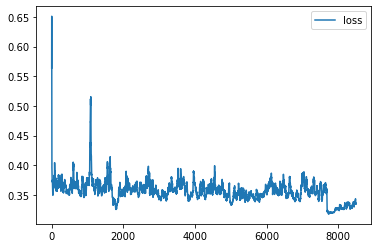

In [11]:
RNN_cell = LSTMCell(freq_map,
                    embedding_size    = EMB_SIZE,
                    hidden_state_size = HID_SIZE,
                    n_cells_hor       = N_CELLS_HOR,
                    n_cells_ver       = N_CELLS_VER,
                    device            = DEVICE)
train_network_RNN (RNN_cell,
                   DEVICE,
                   dataloader_train,
                   n_cycles=N_CYCLES,
                   learning_rate=LEARNING_RATE,
                   earthquake_weight=EARTHQUAKE_WEIGHT,
                   lr_decay=LR_DECAY
                   )

In [12]:
if not os.path.exists("Model"):
    os.mkdir("Model")
torch.save(RNN_cell.state_dict(), "Model/state_dict")